In [22]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.decomposition import PCA

In [23]:
customers_df = pd.read_csv('data/Customers.csv')
transactions_df = pd.read_csv('data/Transactions.csv')
products_df = pd.read_csv('data/Products.csv')

customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'], errors='coerce')
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'], errors='coerce')

customers_df['SignupDate'].fillna(customers_df['SignupDate'].mean(), inplace=True)
transactions_df['TransactionDate'].fillna(transactions_df['TransactionDate'].mean(), inplace=True)

transactions_df['Quantity'].fillna(transactions_df['Quantity'].median(), inplace=True)
transactions_df['TotalValue'].fillna(transactions_df['TotalValue'].median(), inplace=True)
transactions_df['Price'].fillna(transactions_df['Price'].median(), inplace=True)

C:\Users\rajuk\AppData\Local\Temp\ipykernel_4828\3485369675.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customers_df['SignupDate'].fillna(customers_df['SignupDate'].mean(), inplace=True)
C:\Users\rajuk\AppData\Local\Temp\ipykernel_4828\3485369675.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

In [24]:
def calculate_customer_metrics(customers_df, transactions_df):
    current_date = datetime.now()
    customers_df['DaysSinceSignup'] = (current_date - customers_df['SignupDate']).dt.days
    
    customer_metrics = transactions_df.groupby('CustomerID').agg({
        'TransactionID': 'count',
        'TotalValue': ['sum', 'mean'],
        'Quantity': 'sum'
    }).reset_index()
    
    customer_metrics.columns = ['CustomerID', 'TransactionCount', 'TotalSpend', 'AvgTransactionValue', 'TotalQuantity']
    
    transaction_dates = transactions_df.groupby('CustomerID')['TransactionDate'].agg(list).reset_index()
    
    def calc_avg_days_between(dates):
        if len(dates) <= 1:
            return 0
        dates = sorted(dates)
        days_between = [(dates[i+1] - dates[i]).days for i in range(len(dates)-1)]
        return np.mean(days_between)
    
    transaction_dates['AvgDaysBetween'] = transaction_dates['TransactionDate'].apply(calc_avg_days_between)
    customer_metrics = customer_metrics.merge(transaction_dates[['CustomerID', 'AvgDaysBetween']], on='CustomerID')
    
    customers_df['Region'] = customers_df['Region'].fillna('Unknown')
    
    final_df = customers_df[['CustomerID', 'Region', 'DaysSinceSignup']].merge(
        customer_metrics, on='CustomerID', how='left'
    )
    
    numeric_columns = ['TransactionCount', 'TotalSpend', 'AvgTransactionValue', 'TotalQuantity', 'AvgDaysBetween']
    final_df[numeric_columns] = final_df[numeric_columns].fillna(0)
    
    region_dummies = pd.get_dummies(final_df['Region'], prefix='Region')
    final_df = pd.concat([final_df.drop('Region', axis=1), region_dummies], axis=1)
    
    return final_df

In [25]:
clustering_df = calculate_customer_metrics(customers_df, transactions_df)

features_for_clustering = [
    'DaysSinceSignup', 'TransactionCount', 'TotalSpend', 'AvgTransactionValue',
    'TotalQuantity', 'AvgDaysBetween'
] + [col for col in clustering_df.columns if col.startswith('Region_')]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_df[features_for_clustering])

In [26]:
def evaluate_clusters(scaled_features, max_clusters=10):
    inertias = []
    db_scores = []
    silhouette_scores = []
    
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(scaled_features)
        inertias.append(kmeans.inertia_)
        db_scores.append(davies_bouldin_score(scaled_features, kmeans.labels_))
    
    return inertias, db_scores,

In [27]:
inertias, db_scores = evaluate_clusters(scaled_features)


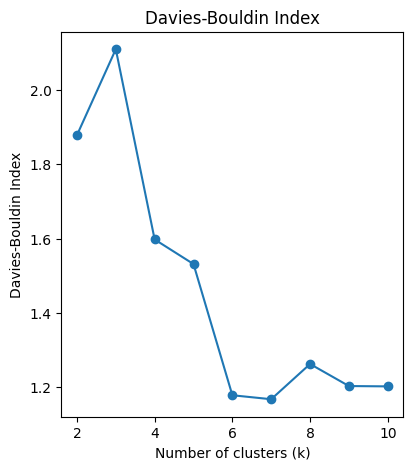

In [28]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 2)
plt.plot(range(2, len(db_scores) + 2), db_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index')
plt.show()

In [33]:
optimal_k = 7
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = final_kmeans.fit_predict(scaled_features)

clustering_df['Cluster'] = clusters

pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

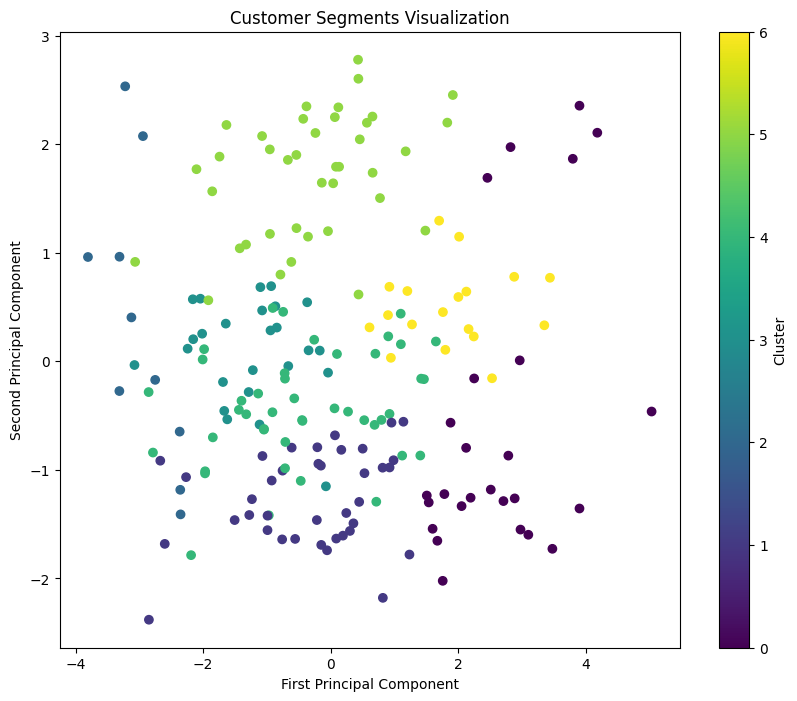


Clustering Results:
Number of clusters: 7
Davies-Bouldin Index: 1.167

Cluster Profiles:
         DaysSinceSignup  TransactionCount   TotalSpend  AvgTransactionValue  \
Cluster                                                                        
0             687.923077          7.730769  6235.181923           823.936849   
1             579.657895          4.578947  2955.628684           649.852490   
2             528.400000          1.000000   340.503000           293.911500   
3             566.080000          3.280000  2204.362400           713.811533   
4             565.250000          4.636364  3232.935455           712.552560   
5             450.769231          4.974359  3025.008205           649.277200   
6             540.500000          7.500000  5379.353889           736.287599   

         TotalQuantity  AvgDaysBetween  Region_Asia  Region_Europe  \
Cluster                                                              
0            22.000000       40.445543          0

In [34]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], c=clusters, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Customer Segments Visualization')
plt.colorbar(scatter, label='Cluster')
plt.show()

print("\nClustering Results:")
print(f"Number of clusters: {optimal_k}")
print(f"Davies-Bouldin Index: {db_scores[optimal_k-2]:.3f}")

cluster_profiles = clustering_df.groupby('Cluster')[features_for_clustering].mean()
print("\nCluster Profiles:")
print(cluster_profiles)
